In [1]:
import gzip
from pathlib import Path
import shutil

RAW_DIR = Path("./pgs_scores/")
OUT_DIR = Path("./data/filtered_pgs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

KEYWORDS = ["breast cancer", "mammary carcinoma"]

def is_breast_cancer(file_path):
    with gzip.open(file_path, "rt", encoding="utf-8", errors="ignore") as f:
        for _ in range(50):  # headers ficam no topo
            line = f.readline().lower()
            if any(k in line for k in KEYWORDS):
                return True
    return False

count = 0
for file in RAW_DIR.glob("PGS*.txt.gz"):
    if is_breast_cancer(file):
        shutil.copy(file, OUT_DIR / file.name)
        count += 1

print(f"Total de PGS de câncer de mama: {count}")

Total de PGS de câncer de mama: 150


In [3]:
import pandas as pd
from pathlib import Path

def load_pgs_file(path: Path) -> pd.DataFrame:
    df = pd.read_csv(
        path,
        sep="\t",
        comment="#",      # ignora metadata
        compression="gzip",
        engine="python"   # mais tolerante
    )
    return df


In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm

# ==============================
# Configuração
# ==============================
PGS_DIR = Path("./data/filtered_pgs")
OUT = Path("./data/matrices/genetic_features.csv")
OUT.parent.mkdir(parents=True, exist_ok=True)


# ==============================
# Funções utilitárias
# ==============================
def load_pgs_file(path: Path) -> pd.DataFrame:
    """
    Lê um arquivo de scoring do PGS Catalog de forma robusta.
    """
    return pd.read_csv(
        path,
        sep="\t",
        comment="#",
        compression="gzip",
        engine="python"
    )


def get_effect_weights(df: pd.DataFrame) -> pd.Series:
    """
    Extrai o vetor de pesos genéticos de forma universal,
    independentemente do formato do PGS.
    """
    if "effect_weight" in df.columns:
        return df["effect_weight"].astype(float)
    elif "beta" in df.columns:
        return df["beta"].astype(float)
    elif "OR" in df.columns:
        # fallback matematicamente correto
        return np.log(df["OR"].astype(float))
    else:
        raise ValueError("Nenhuma coluna de peso encontrada no arquivo")


def extract_pgs_features(df: pd.DataFrame) -> dict:
    """
    Extrai features globais de um score poligênico.
    Essas features representam o 'fingerprint genético' do PGS.
    """
    w = get_effect_weights(df)

    return {
        "n_snps": len(w),
        "mean_weight": w.mean(),
        "std_weight": w.std(),
        "sum_abs_weight": w.abs().sum(),
        "max_weight": w.max(),
        "min_weight": w.min(),
        "pos_ratio": (w > 0).mean(),
        "neg_ratio": (w < 0).mean(),
    }


# ==============================
# Pipeline principal
# ==============================
rows = []

files = sorted(PGS_DIR.glob("PGS*.txt.gz"))

print(f"Processando {len(files)} arquivos PGS...")

for file in tqdm(files):
    pgs_id = file.stem.replace(".txt", "")

    try:
        df = load_pgs_file(file)
        feats = extract_pgs_features(df)
        feats["pgs_id"] = pgs_id
        rows.append(feats)

    except Exception as e:
        # Falha controlada — não quebra o pipeline
        print(f"[ERRO] {pgs_id}: {e}")

# ==============================
# DataFrame final
# ==============================
X = pd.DataFrame(rows).set_index("pgs_id")

# Remove scores quebrados ou vazios (raro, mas acontece)
X = X.dropna()

X.to_csv(OUT)

print("Matriz criada com sucesso:", OUT)
print("Shape final:", X.shape)


Processando 150 arquivos PGS...


 90%|████████████████████████████████████████████████████████████████████████        | 135/150 [03:55<00:37,  2.47s/it]

[ERRO] PGS004299: Nenhuma coluna de peso encontrada no arquivo


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [04:58<00:00,  1.99s/it]

Matriz criada com sucesso: data\matrices\genetic_features.csv
Shape final: (149, 8)


In [5]:
import pandas as pd

X = pd.read_csv("./data/matrices/genetic_features.csv", index_col=0)
print(X.shape)
print(X.describe())

(149, 8)
             n_snps   mean_weight  std_weight  sum_abs_weight  max_weight  \
count  1.490000e+02  1.490000e+02  149.000000      149.000000  149.000000   
mean   3.636437e+05  7.744440e-02    0.090489      137.413590    0.538324   
std    9.223532e+05  7.092907e-01    0.377865     1049.863141    3.196092   
min    9.000000e+00 -4.555263e-01    0.000004        0.095047    0.000037   
25%    8.800000e+01  2.203786e-07    0.000884        5.749589    0.026310   
50%    3.300000e+02  1.733350e-03    0.047393       15.287600    0.204799   
75%    1.183880e+05  1.750129e-02    0.089389       59.788288    0.343500   
max    6.494889e+06  8.600247e+00    4.443315    12738.675953   38.620000   

       min_weight   pos_ratio   neg_ratio  
count  149.000000  149.000000  149.000000  
mean    -0.147349    0.579116    0.419335  
std      0.665270    0.155046    0.156500  
min     -4.332000    0.328947    0.000000  
25%     -0.238705    0.499770    0.428571  
50%     -0.078745    0.520721    

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
import torch
import torch.nn as nn

class GeneticAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=3):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


In [8]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

model = GeneticAutoencoder(input_dim=X.shape[1], latent_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(500):
    optimizer.zero_grad()
    X_hat, _ = model(X_tensor)
    loss = loss_fn(X_hat, X_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Loss {loss.item():.6f}")


Epoch 0 | Loss 1.035972
Epoch 50 | Loss 0.846352
Epoch 100 | Loss 0.502691
Epoch 150 | Loss 0.259360
Epoch 200 | Loss 0.159620
Epoch 250 | Loss 0.101000
Epoch 300 | Loss 0.053539
Epoch 350 | Loss 0.033690
Epoch 400 | Loss 0.021705
Epoch 450 | Loss 0.012926


In [9]:
with torch.no_grad():
    _, Z = model(X_tensor)

Z = Z.numpy()


In [10]:
Z_df = pd.DataFrame(
    Z,
    index=X.index,
    columns=["z1", "z2", "z3"]
)

Z_df.to_csv("./data/matrices/genetic_latent_space.csv")


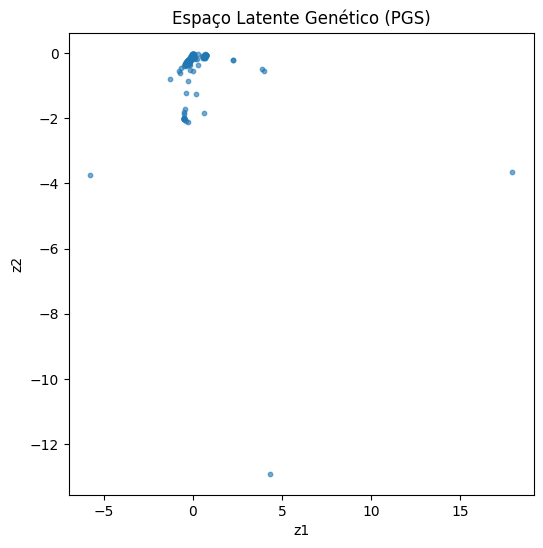

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(Z_df["z1"], Z_df["z2"], s=10, alpha=0.6)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Espaço Latente Genético (PGS)")
plt.show()


In [12]:
import pandas as pd

X = pd.read_csv(
    "./data/matrices/genetic_features.csv",
    index_col=0
)

print("Shape:", X.shape)
print(X.head())


Shape: (149, 8)
           n_snps  mean_weight  std_weight  sum_abs_weight  max_weight  \
pgs_id                                                                   
PGS000001      77     0.023460    0.093698        6.206064    0.309835   
PGS000002      77     0.024615    0.105375        6.623123    0.410851   
PGS000003      77     0.017501    0.087784        5.093481    0.379737   
PGS000004     313     0.003891    0.071328       18.978100    0.268700   
PGS000005     313     0.003975    0.076275       19.709700    0.281200   

           min_weight  pos_ratio  neg_ratio  
pgs_id                                       
PGS000001   -0.155134   0.610390   0.389610  
PGS000002   -0.163107   0.571429   0.428571  
PGS000003   -0.176618   0.597403   0.402597  
PGS000004   -0.260900   0.514377   0.485623  
PGS000005   -0.327000   0.520767   0.479233  


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
Z_pca = pca.fit_transform(X_scaled)


In [15]:
print("Variância explicada por componente:")
for i, v in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {v:.3f}")


Variância explicada por componente:
PC1: 0.462
PC2: 0.223
PC3: 0.162


In [17]:
import torch
import torch.nn as nn

class GeneticAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=3):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


In [18]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

model = GeneticAutoencoder(
    input_dim=X.shape[1],
    latent_dim=3
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(500):
    optimizer.zero_grad()
    X_hat, _ = model(X_tensor)
    loss = loss_fn(X_hat, X_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Loss {loss.item():.6f}")


Epoch 0 | Loss 1.096220
Epoch 50 | Loss 0.949090
Epoch 100 | Loss 0.641505
Epoch 150 | Loss 0.252106
Epoch 200 | Loss 0.122135
Epoch 250 | Loss 0.056629
Epoch 300 | Loss 0.036459
Epoch 350 | Loss 0.026587
Epoch 400 | Loss 0.019707
Epoch 450 | Loss 0.014709


In [19]:
with torch.no_grad():
    _, Z_ae = model(X_tensor)

Z_ae = Z_ae.numpy()


In [20]:
Z_pca_df = pd.DataFrame(
    Z_pca,
    index=X.index,
    columns=["pc1", "pc2", "pc3"]
)

Z_ae_df = pd.DataFrame(
    Z_ae,
    index=X.index,
    columns=["z1", "z2", "z3"]
)

Z_pca_df.to_csv("./data/matrices/pca_latent_space.csv")
Z_ae_df.to_csv("./data/matrices/autoencoder_latent_space.csv")


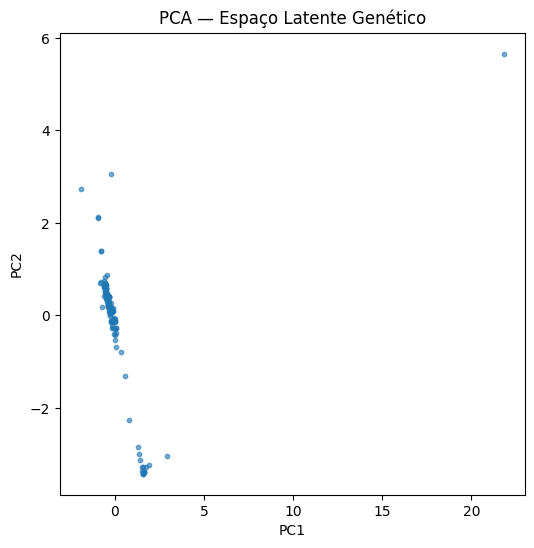

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(
    Z_pca_df["pc1"],
    Z_pca_df["pc2"],
    s=10,
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA — Espaço Latente Genético")
plt.show()


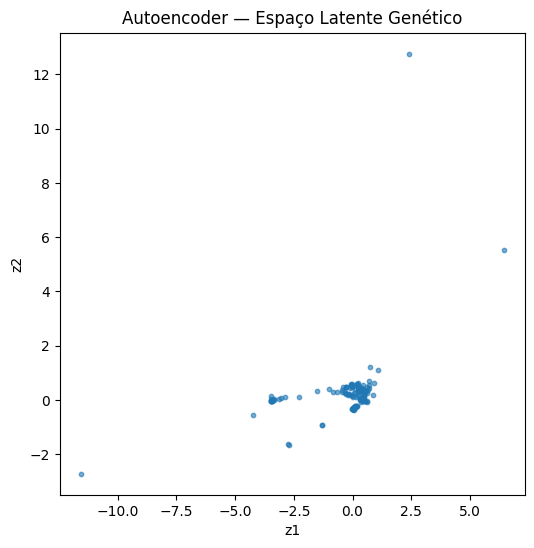

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(
    Z_ae_df["z1"],
    Z_ae_df["z2"],
    s=10,
    alpha=0.6
)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Autoencoder — Espaço Latente Genético")
plt.show()
